In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15960137.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 508247.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4410642.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10624946.33it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [6]:
class VG11(nn.Module):
  def __init__(self):
        super(VG11, self).__init__()
        self.features = nn.Sequential(
            ################################################
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ################################################
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ################################################
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            ################################################
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ################################################
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ################################################
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ################################################
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ################################################
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ################################################
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


In [7]:
model = VG11()
params = list(model.parameters())
print(len(params))
print(params[0].size())

38
torch.Size([64, 1, 3, 3])


In [8]:
# Train

import torch.optim as optim

# Parameters
learning_rate = 0.01
momentum = 0.9  # momentum factor used in paper

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    training_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() * data.size(0) # get the average loss * batch size = total loss for the batch
        _, predicted = output.max(1) # the highest number and index among all the classes for all samples.
        total += target.size(0)  # Essentially adding up the samples
        correct += predicted.eq(target).sum().item() # get the number of correctly classified samples in the batch
    train_loss = training_loss / total # average loss per sample
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy



# Assuming CUDA is available and the model, criterion have been defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VG11(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [9]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0) # get the average loss * batch size = total loss for the batch
            _, predicted = output.max(1) # the highest number among all the classes for all samples.
            total += target.size(0) # Essentially the batch size
            correct += predicted.eq(target).sum().item() # get the number of correctly classified samples in the batch
    test_loss = test_loss / total # average loss per sample
    test_accuracy = 100. * correct / total # get the % of correctly classified samples
    return test_loss, test_accuracy

In [10]:
# Lists to store metrics
epochs = 5
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Training and testing loop
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Accuracy')

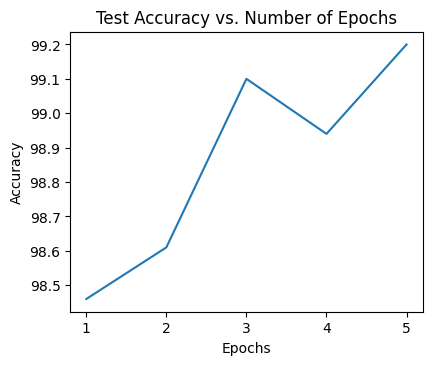

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

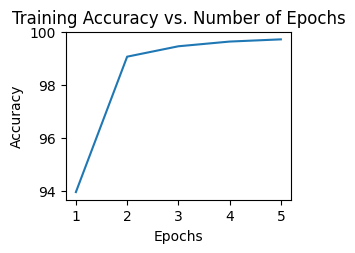

In [13]:
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

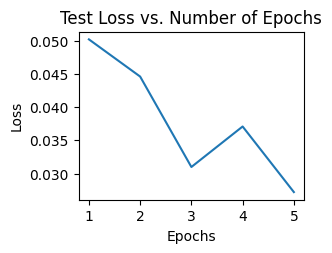

In [14]:
plt.subplot(2, 2, 3)
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.title('Test Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

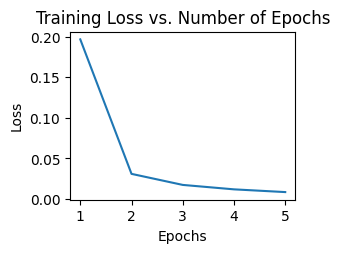

In [15]:
plt.subplot(2, 2, 4)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [17]:
transform_original = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform_horizontal_flip = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_vertical_flip = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Loaders
test_loader_original = DataLoader(datasets.MNIST(root='./data', train=False, transform=transform_original), batch_size=256)
test_loader_horizontal = DataLoader(datasets.MNIST(root='./data', train=False, transform=transform_horizontal_flip), batch_size=256)
test_loader_vertical = DataLoader(datasets.MNIST(root='./data', train=False, transform=transform_vertical_flip), batch_size=256)

In [18]:
print("Testing on original images:")
loss_original, accuracy_original = test(model, device, test_loader_original, criterion) # is this fine?

print("Testing on horizontally flipped images:")
loss_horizontal, accuracy_horizontal = test(model, device, test_loader_horizontal, criterion)

print("Testing on vertically flipped images:")
loss_vertical, accuracy_vertical = test(model, device, test_loader_vertical, criterion)

Testing on original images:
Testing on horizontally flipped images:
Testing on vertically flipped images:


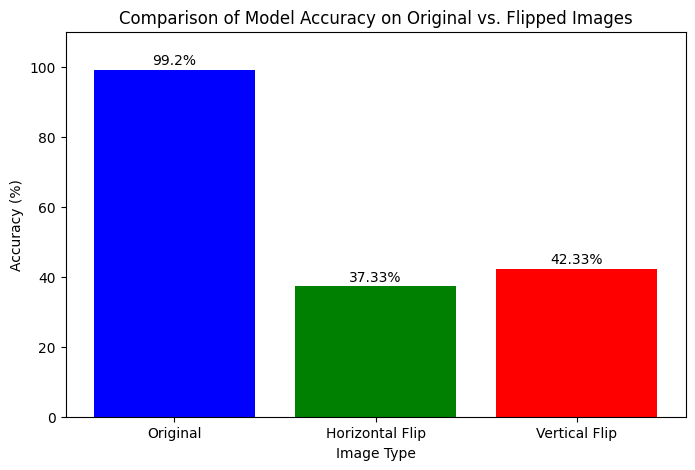

In [19]:
accuracies = {
    'Original': accuracy_original,  # Example accuracy of the model on original images
    'Horizontal Flip': accuracy_horizontal,  # Example accuracy on horizontally flipped images
    'Vertical Flip': accuracy_vertical  # Example accuracy on vertically flipped images
}

# Names of the groups
labels = list(accuracies.keys())

# Values from the accuracies dictionary
values = [accuracies[label] for label in labels]

# Creating the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])  # Plot bars with different colors

# Adding title and labels
plt.title('Comparison of Model Accuracy on Original vs. Flipped Images')
plt.xlabel('Image Type')
plt.ylabel('Accuracy (%)')

# Adding value labels on top of each bar
for i in range(len(values)):
    plt.text(i, values[i] + 0.5, f'{values[i]}%', ha='center', va='bottom')

# Show the plot
plt.ylim(0, 110)   # Set limits for Y-axis for better visual comparison
plt.show()

In [20]:
def gaussian_noise_transform(variance):
    return transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.randn_like(x) * variance**0.5),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Create test loaders with different noise levels
variances = [0.01, 0.1, 1]
test_loaders = {var: DataLoader(datasets.MNIST('./data', train=False, download=True,
                                               transform=gaussian_noise_transform(var)),
                                    batch_size=256, shuffle=False)
                for var in variances}

In [21]:
accuracies = {}
for var, loader in test_loaders.items():
    loss, accuracy = test(model, device, loader, criterion)
    accuracies[f"{var} Variance"] = accuracy

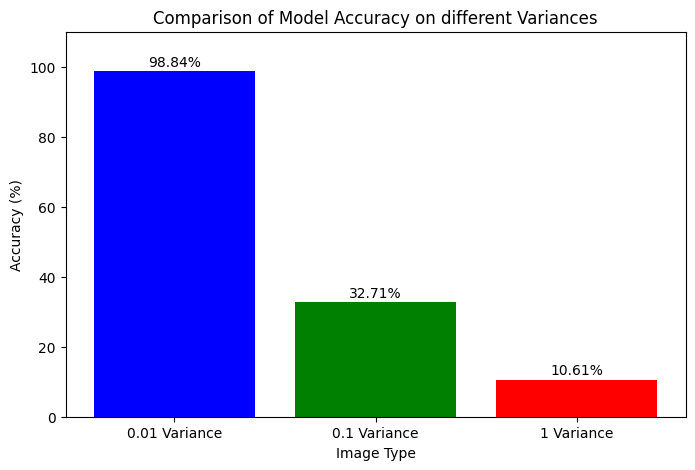

In [22]:
labels = list(accuracies.keys())
values = [accuracies[label] for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Comparison of Model Accuracy on different Variances')
plt.xlabel('Image Type')
plt.ylabel('Accuracy (%)')

# Adding value labels on top of each bar
for i in range(len(values)):
    plt.text(i, values[i] + 0.5, f'{values[i]}%', ha='center', va='bottom')

# Show the plot
plt.ylim(0, 110)   # Set limits for Y-axis for better visual comparison
plt.show()

In [32]:
## 2.4

## Transformations

transform_original = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform_horizontal_flip = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_vertical_flip = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform_001 = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01**0.5),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])


transform_01 = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1**0.5),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])


transform_1 = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 1**0.5),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

list_of_transforms = [
    lambda x: x, # Do nothing
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01**0.5),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1**0.5),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 1**0.5),
]


In [33]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [34]:
def augmented_train(model, device, train_loader, optimizer, criterion):
    model.train()
    training_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        transform = random.choice(list_of_transforms)
        data = torch.stack([transform(img) for img in data])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() * data.size(0) # get the average loss * batch size = total loss for the batch
        _, predicted = output.max(1) # the highest number and index among all the classes for all samples.
        total += target.size(0)  # Essentially adding up the samples
        correct += predicted.eq(target).sum().item() # get the number of correctly classified samples in the batch
    train_loss = training_loss / total # average loss per sample
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

In [35]:
# Training and testing loop
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = augmented_train(model, device, train_loader, optimizer, criterion)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

In [36]:
baseline_accuracy = test_accuracies[-1]

In [37]:
print("Testing on horizontally flipped images:")
loss_horizontal, accuracy_horizontal = test(model, device, test_loader_horizontal, criterion)

print("Testing on vertically flipped images:")
loss_vertical, accuracy_vertical = test(model, device, test_loader_vertical, criterion)

Testing on horizontally flipped images:
Testing on vertically flipped images:


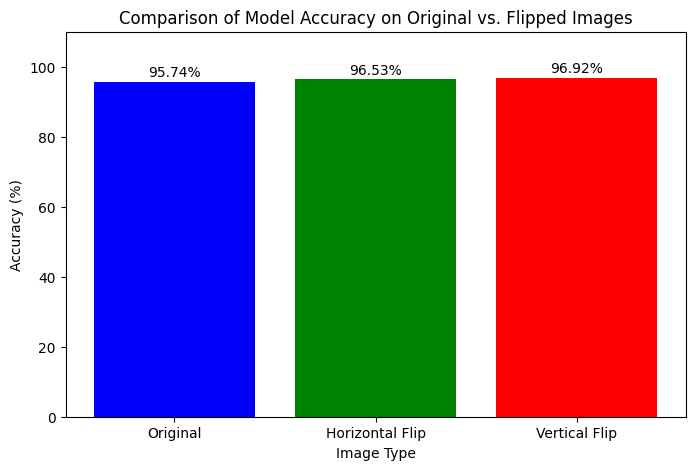

In [38]:
accuracies = {
    'Original': baseline_accuracy,  # Example accuracy of the model on original images
    'Horizontal Flip': accuracy_horizontal,  # Example accuracy on horizontally flipped images
    'Vertical Flip': accuracy_vertical  # Example accuracy on vertically flipped images
}

# Names of the groups
labels = list(accuracies.keys())

# Values from the accuracies dictionary
values = [accuracies[label] for label in labels]

# Creating the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])  # Plot bars with different colors

# Adding title and labels
plt.title('Comparison of Model Accuracy on Original vs. Flipped Images')
plt.xlabel('Image Type')
plt.ylabel('Accuracy (%)')

# Adding value labels on top of each bar
for i in range(len(values)):
    plt.text(i, values[i] + 0.5, f'{values[i]}%', ha='center', va='bottom')

# Show the plot
plt.ylim(0, 110)
plt.show()

In [39]:
test_loaders = {var: DataLoader(datasets.MNIST('./data', train=False, download=True,
                                               transform=gaussian_noise_transform(var)),
                                    batch_size=256, shuffle=False)
                for var in variances}

accuracies = {}
for var, loader in test_loaders.items():
    loss, accuracy = test(model, device, loader, criterion)
    accuracies[f"{var} Variance"] = accuracy

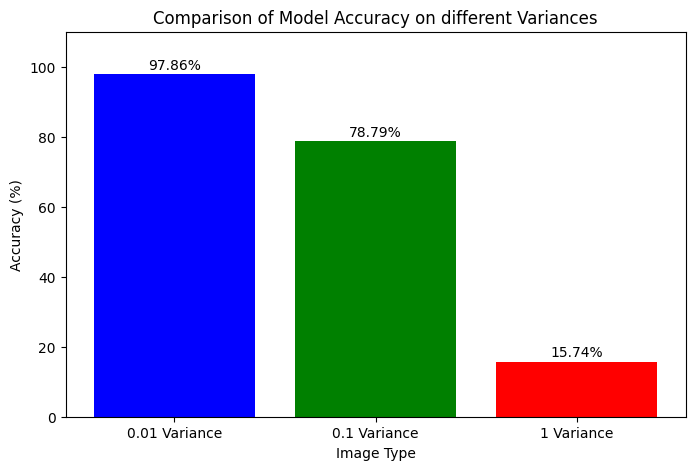

In [40]:
labels = list(accuracies.keys())
values = [accuracies[label] for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Comparison of Model Accuracy on different Variances')
plt.xlabel('Image Type')
plt.ylabel('Accuracy (%)')

# Adding value labels on top of each bar
for i in range(len(values)):
    plt.text(i, values[i] + 0.5, f'{values[i]}%', ha='center', va='bottom')

# Show the plot
plt.ylim(0, 110)
plt.show()